# Modelling Strategie
- Problem = **Classification**
- Target = **class (we gonna cut in bins a given target, it might be a team goal scored or conceded...)**
- Features = **goal averages for team at home and away**

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

### Feature Engineering

In [90]:
path = Path.cwd().parent.parent / 'data' / '2022_23' / 'results' / 'ligue1.csv'
df = pd.read_csv(path, parse_dates=True, index_col='date_time')
df.head()

,journée,home_team,away_team,1st_home_team_goal,1st_away_team_goal,1st_total_goal,2nd_home_team_goal,2nd_away_team_goal,2nd_total_goal,total_home_team_goal,total_away_team_goal,global
date_time,,,,,,,,,,,,
2023-06-03 19:00:00,38,AC Ajaccio,Marseille,0,0,0,1,0,1,1,0,1
2023-06-03 19:00:00,38,Nice,Lyon,3,1,4,0,0,0,3,1,4
2023-06-03 19:00:00,38,Troyes,Lille,0,0,0,1,1,2,1,1,2
2023-06-03 19:00:00,38,Reims,Montpellier,1,0,1,0,3,3,1,3,4
2023-06-03 19:00:00,38,PSG,Clermont,2,2,4,0,1,1,2,3,5


In [91]:
def feature_engineering(df):
    """This function aims to create new features
    It will calculate for each team
    the average of goal after each daymatch
    """
    data = df.copy()
    data = data.sort_values(by='journée', ascending=True)
    data = data[['journée', 'home_team', 'away_team', 'total_home_team_goal',
                     'total_away_team_goal', 'global']]
    for row in data.iterrows():
        at_home = data[data['home_team']==data['home_team']]
        at_away = data[data['away_team']==data['away_team']]
        data['ht_scored_avg'] = at_home.groupby('home_team')['total_home_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['ht_conceded_avg'] = at_home.groupby('home_team')['total_away_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['at_scored_avg'] = at_away.groupby('away_team')['total_away_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['at_conceded_avg'] = at_away.groupby('away_team')['total_home_team_goal'].transform(lambda x: x.expanding().mean().shift())
    return data[data['journée']>2]

In [92]:
dataset = feature_engineering(df)
dataset.head()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global,ht_scored_avg,ht_conceded_avg,at_scored_avg,at_conceded_avg
date_time,,,,,,,,,,
2022-08-21 18:45:00,3,Lille,PSG,1,7,8,4.0,1.0,5.0,0.0
2022-08-21 15:05:00,3,Rennes,AC Ajaccio,2,1,3,0.0,1.0,1.0,2.0
2022-08-21 13:00:00,3,Clermont,Nice,1,0,1,0.0,5.0,1.0,1.0
2022-08-21 13:00:00,3,Angers,Brest,1,3,4,0.0,0.0,2.0,3.0
2022-08-20 15:00:00,3,Monaco,Lens,1,4,5,1.0,1.0,0.0,0.0


code = {
        'under 2.5': 0,
        'over 2.5': 1}
dataset['class'] = dataset['class'].map(code)

### MODELLING

In [93]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [94]:
# X represent the feature used to make prediction
# We will take the scored average for the team at home 
# and the conceded average for team at away before the present match
# in order to predict goal scored of team at home 
# (note that goal scored of a team is also the goal conceded of the other team)
X = dataset[['ht_scored_avg', 'at_conceded_avg']]
y = pd.cut(x=dataset['total_home_team_goal'], bins=[min(dataset['total_home_team_goal']), 2,
                                                    max(dataset['total_home_team_goal'])],
                                                    labels=['under 2.5', 'over 2.5'], include_lowest=True)
# We gonna split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [96]:
def training_RFC(x_train, y_train, model):
    """This fonction aims to train the model selected
    Tuning to find the best parameter given
    Test our model on the test set
    and show some metrics to evaluate performance of the model
    
    Returns:
        estimator: the estimator with the best score
    """
    parameter = [{'n_estimators': range(1, 15),
                  'max_depth': range(1, 15)}]
    grid = GridSearchCV(estimator=model, param_grid=parameter, scoring='accuracy', cv=5)
    grid.fit(x_train, y_train)
    print(f"best estimator:{grid.best_estimator_}")
    print(f"best score: {grid.best_score_}")
    return grid.best_estimator_

In [97]:
def evaluation(x_test, y_test, model):
    """Test our model on the test set
    and show some metrics to evaluate performance of the model
    """
    print(f"Final Score {model.__class__.__name__} : {model.score(x_test, y_test)}")
    print(confusion_matrix(y_test, model.predict(x_test)))
    print(classification_report(y_test, model.predict(x_test)))

    N, train_score, val_score = learning_curve(
        model, x_train, y_train, train_sizes= np.linspace(0.1, 1.0, 10), cv=5
    )

    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.xlabel('train size')
    plt.legend()
    plt.show()

In [98]:
estimator = training_RFC(X, y, RandomForestClassifier(random_state=22))

best estimator:RandomForestClassifier(max_depth=5, n_estimators=9, random_state=22)
best score: 0.825


Final Score RandomForestClassifier : 0.8638888888888889
[[ 18  48]
 [  1 293]]
              precision    recall  f1-score   support

    over 2.5       0.95      0.27      0.42        66
   under 2.5       0.86      1.00      0.92       294

    accuracy                           0.86       360
   macro avg       0.90      0.63      0.67       360
weighted avg       0.88      0.86      0.83       360



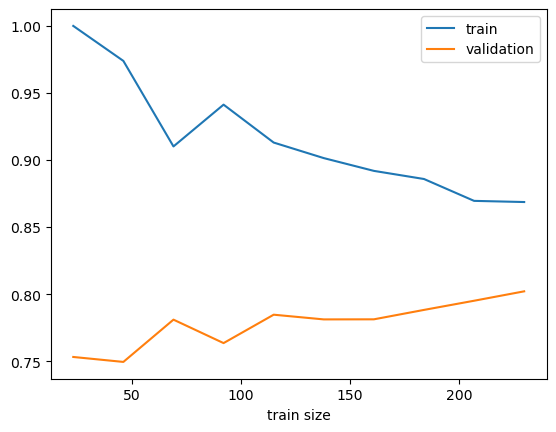

In [99]:
evaluation(X, y, model=estimator)

### Interpretation 
After completion of the modelling strategie, we can notice that the RandomForestClassifier give us a good score, but when we look close of it, there's a thing\
our class is very unbalanced, so the majoritary class is predict better than the other one, beside our model seems have underfitting issue.\
We gonna test other model like the SVM, who is robust to unbalanced classes.


In [100]:
def training_svc(x_train, y_train, model):
    """This fonction aims to train the model selected
    Tuning to find the best parameter given
    Test our model on the test set
    and show some metrics to evaluate performance of the model
    
    Returns:
        estimator: the estimator with the best score
    """
    parameter = [{'kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
                  'C': range(1, 5),
                  'class_weight': ['balanced']}]
    grid = GridSearchCV(estimator=model, param_grid=parameter, scoring='accuracy', cv=5)
    grid.fit(x_train, y_train)
    print(f"best estimator:{grid.best_estimator_}")
    print(f"best score: {grid.best_score_}")
    return grid.best_estimator_

In [101]:
estimator = training_svc(x_train, y_train, svm.SVC())

best estimator:SVC(C=1, class_weight='balanced', kernel='poly')
best score: 0.7497882637628555


Final Score SVC : 0.8194444444444444
[[ 7  7]
 [ 6 52]]
              precision    recall  f1-score   support

    over 2.5       0.54      0.50      0.52        14
   under 2.5       0.88      0.90      0.89        58

    accuracy                           0.82        72
   macro avg       0.71      0.70      0.70        72
weighted avg       0.81      0.82      0.82        72



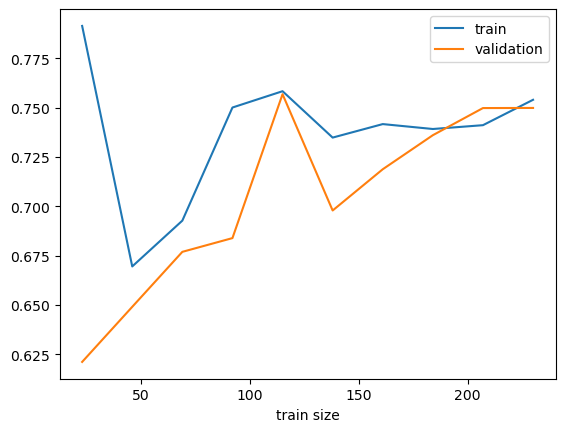

In [102]:
evaluation(x_test, y_test, model=estimator)

### Interpretation
The SVC model trained not offer a better result than the RFClassifier.\
But it seems generalized well than the other one.
We will see if adding more data can improve the accuracy of our model.

In [109]:
# We gonna connect to the database and retrieve some data in the current saison 2023 / 2024
import pymysql
import os
connection = pymysql.connect(
    host='localhost',
    database='football',
    user='hh',
    passwd=os.environ.get('DB_PWD')
)
with connection.cursor() as cur:
    request = 'SELECT journée, date_time, home_team, away_team, total_home_team_goal, total_away_team_goal, global\
               FROM l1_summary'
    cur.execute(request)
    results = cur.fetchall()
    results = pd.DataFrame(results, columns=['journée', 'date_time',
                                             'home_team', 'away_team',
                                             'total_home_team_goal', 'total_away_team_goal',
                                             'global'])

In [113]:
results.set_index('date_time', inplace=True)
results.head()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global
date_time,,,,,,
2023-08-11 19:00:00,1,Nice,Lille,1,1,2
2023-08-12 15:00:00,1,Marseille,Reims,2,1,3
2023-08-12 19:00:00,1,PSG,Lorient,0,0,0
2023-08-13 11:00:00,1,Brest,Lens,3,2,5
2023-08-13 13:00:00,1,Clermont,Monaco,2,4,6


In [114]:
data = feature_engineering(results)

In [115]:
data.head()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global,ht_scored_avg,ht_conceded_avg,at_scored_avg,at_conceded_avg
date_time,,,,,,,,,,
2023-08-27 18:45:00,3,Nice,Lyon,0,0,0,1.0,1.0,1.0,2.0
2023-08-27 15:05:00,3,Lorient,Lille,4,1,5,1.0,1.0,1.0,1.0
2023-08-27 13:00:00,3,Strasbourg,Toulouse,2,0,2,2.0,1.0,2.0,1.0
2023-08-27 13:00:00,3,Montpellier,Reims,1,3,4,2.0,2.0,1.0,2.0
2023-08-27 13:00:00,3,Clermont,Metz,0,1,1,2.0,4.0,1.0,5.0


In [117]:
dataset.head()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global,ht_scored_avg,ht_conceded_avg,at_scored_avg,at_conceded_avg
date_time,,,,,,,,,,
2022-08-21 18:45:00,3,Lille,PSG,1,7,8,4.0,1.0,5.0,0.0
2022-08-21 15:05:00,3,Rennes,AC Ajaccio,2,1,3,0.0,1.0,1.0,2.0
2022-08-21 13:00:00,3,Clermont,Nice,1,0,1,0.0,5.0,1.0,1.0
2022-08-21 13:00:00,3,Angers,Brest,1,3,4,0.0,0.0,2.0,3.0
2022-08-20 15:00:00,3,Monaco,Lens,1,4,5,1.0,1.0,0.0,0.0


In [118]:
# We have to concatenate our two data set 
Dataset = pd.concat([dataset, data], axis=0)

In [119]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 468 entries, 2022-08-21 18:45:00 to 2023-12-02 16:00:00
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   journée               468 non-null    int64  
 1   home_team             468 non-null    object 
 2   away_team             468 non-null    object 
 3   total_home_team_goal  468 non-null    int64  
 4   total_away_team_goal  468 non-null    int64  
 5   global                468 non-null    int64  
 6   ht_scored_avg         468 non-null    float64
 7   ht_conceded_avg       468 non-null    float64
 8   at_scored_avg         468 non-null    float64
 9   at_conceded_avg       468 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 40.2+ KB


In [124]:

X = Dataset[['ht_scored_avg', 'at_conceded_avg']]
y = pd.cut(x=Dataset['total_home_team_goal'], bins=[min(Dataset['total_home_team_goal']), 2,
                                                    max(Dataset['total_home_team_goal'])],
                                                    labels=['under 2.5', 'over 2.5'], include_lowest=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [125]:
estimator = training_svc(x_train, y_train, model=svm.SVC())

best estimator:SVC(C=1, class_weight='balanced', kernel='poly')
best score: 0.7112072072072072


Final Score SVC : 0.7446808510638298
[[ 3  9]
 [15 67]]
              precision    recall  f1-score   support

    over 2.5       0.17      0.25      0.20        12
   under 2.5       0.88      0.82      0.85        82

    accuracy                           0.74        94
   macro avg       0.52      0.53      0.52        94
weighted avg       0.79      0.74      0.77        94



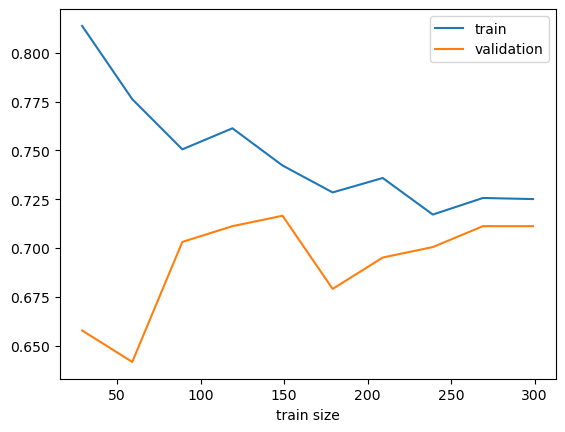

In [126]:
evaluation(x_test, y_test, model=estimator)

### Interpretation
For now, adding more data, does not improve the model score, but I want to know if we mixed several league data into one dataset,\
how the model will behave ? Does this benefit to our model or not ?

In [127]:
from joblib import dump, load
dump(estimator, '../machine_learning/models/SVC_clf.joblib')

['../machine_learning/models/SVC_clf.joblib']

In [ ]:
# We have to evaluate the model
# Check if the same pattern used for make prediction
# can be used on other league like premier league and give us a good score
path = Path.cwd().parent.parent / 'data' / '2022_23' / 'results' / 'premier_league.csv'
df2 = pd.read_csv(path, parse_dates=True, index_col='date_time')
df2.head()

,Unnamed: 0,journée,home_team,away_team,1st_home_team_goal,1st_away_team_goal,total_home_team_goal,total_away_team_goal,global
date_time,,,,,,,,,
2023-05-28 15:30:00,0,38,Arsenal,Wolves,3,0,5,0,5
2023-05-28 15:30:00,1,38,Aston Villa,Brighton,2,1,2,1,3
2023-05-28 15:30:00,2,38,Brentford,Manchester City,0,0,1,0,1
2023-05-28 15:30:00,3,38,Chelsea,Newcastle,1,1,1,1,2
2023-05-28 15:30:00,4,38,Crystal Palace,Nottingham,0,1,1,1,2


In [128]:
dataset2 = feature_engineering(df2)


In [129]:
dataset2.head()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global,ht_scored_avg,ht_conceded_avg,at_scored_avg,at_conceded_avg
date_time,,,,,,,,,,
2022-08-22 19:00:00,3,Manchester Utd,Liverpool,2,1,3,1.0,2.0,2.0,2.0
2022-08-21 15:30:00,3,Newcastle,Manchester City,3,3,6,2.0,0.0,2.0,0.0
2022-08-21 13:00:00,3,West Ham,Brighton,0,2,2,0.0,2.0,2.0,1.0
2022-08-21 13:00:00,3,Leeds,Chelsea,3,0,3,2.0,1.0,1.0,0.0
2022-08-20 16:30:00,3,Bournemouth,Arsenal,0,3,3,2.0,0.0,2.0,0.0


In [130]:
feature = dataset2[['ht_scored_avg', 'at_conceded_avg']]
target = pd.cut(x=dataset2['total_home_team_goal'], bins=[min(dataset2['total_home_team_goal']), 2,
                                                    max(dataset2['total_home_team_goal'])],
                                                    labels=['under 2.5', 'over 2.5'], include_lowest=True)

In [131]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=55) 

In [132]:
SVC_clf = load('../machine_learning/models/SVC_clf.joblib')

In [133]:
print(SVC_clf.score(x_test, y_test))
print(confusion_matrix(y_test, SVC_clf.predict(x_test)))
print(classification_report(y_test, SVC_clf.predict(x_test)))

0.625
[[ 7 13]
 [14 38]]
              precision    recall  f1-score   support

    over 2.5       0.33      0.35      0.34        20
   under 2.5       0.75      0.73      0.74        52

    accuracy                           0.62        72
   macro avg       0.54      0.54      0.54        72
weighted avg       0.63      0.62      0.63        72

